Apply the dimensionality reduction algorithms to the two datasets and describe what you see.

In [304]:
import pandas as pd
import numpy as np
import random as rnd
import re
import pickle

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score, balanced_accuracy_score

In [3]:
SEED = 1

# 1. Dataset

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy import stats

## 1.1 Image Segmentation Dataset

In [146]:
features = 'REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN'
col_names = features.split(',') + ['Class']
# print(col_names)

dataset_dir = '../Datasets/statlog_image_segmentation'
df_ims = pd.read_csv(dataset_dir + '/segment.dat', names=col_names, sep=' ')
print(df_ims.shape)

# df_ims['Class'].unique()

# df_ims.describe()

## Separate labels
column_names = df_ims.columns
y = df_ims['Class'].copy().values
X = df_ims.drop(['Class'], axis=1).values
# to 0 - N-1
y = y-1

## Standardize feature data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

new_names = ['x%d'%(i+1) for i in range(len(column_names[:-1]))]
df = pd.DataFrame(X_scaled, columns=new_names)
df['Class'] = y

df_ims_scaled = df

## image segmentation
# column_names = df_ims_scaled.columns
# y = df_ims_scaled['Class'].copy().values
# X = df_ims_scaled.drop(['Class'], axis=1).values

y = df_ims_scaled['Class']
X = df_ims_scaled.drop(['Class'], axis=1)


X_ims, X_ims_test, y_ims, y_ims_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_ims.reset_index(drop=True, inplace=True)
X_ims_test.reset_index(drop=True, inplace=True)
y_ims.reset_index(drop=True, inplace=True)
y_ims_test.reset_index(drop=True, inplace=True)

df_ims = X_ims.copy()
df_ims['Class'] = y_ims

# df_ims_scaled.head()
# X_ims.head()
# df_ims.head()

## 1.2 Audit Dataset

In [135]:
dataset_dir = '../Datasets/audit_data/'
df_aud = pd.read_csv(dataset_dir + '/audit_risk.csv', sep=',')
print(df_aud.shape)

column_names = df_aud.columns

df_aud = df_aud.dropna()
s1 = df_aud['LOCATION_ID']
isnum = s1.str.isnumeric()
df_aud = df_aud[isnum]

y = df_aud['Risk'].astype('int')
X = df_aud.drop(['Risk'], axis=1).values

## Standardize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# new_names = ['x%d'%(i+1) for i in range(len(column_names[:-1]))]
df_aud_scaled = pd.DataFrame(X_scaled, columns=column_names[:-1])
df_aud_scaled['Risk'] = y

X = df_aud_scaled.drop(['Risk'], axis=1)

X_aud, X_aud_test, y_aud, y_aud_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

X_aud.reset_index(drop=True, inplace=True)
X_aud_test.reset_index(drop=True, inplace=True)
y_aud.reset_index(drop=True, inplace=True)
y_aud_test.reset_index(drop=True, inplace=True)

df_aud = X_aud.copy()
df_aud['Class'] = y_aud

# df_aud_scaled.head()
# X_aud.head()
# df_aud.head()

# 2. Dimensionality Reduction Algorithms

* PCA
* ICA
* Randomized Projections
* Any other feature selection algorithm you desire

In [69]:
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## 2.1 PCA

### 2.1.1 Image Segmentation

In [390]:
## compute pca
pca = PCA(random_state=SEED)
pca.fit(X_ims)

eighen_value_ims = pca.explained_variance_
eighen_ratio_ims = pca.explained_variance_ratio_


Text(5, 0.2, 'sum(:8)=0.92')

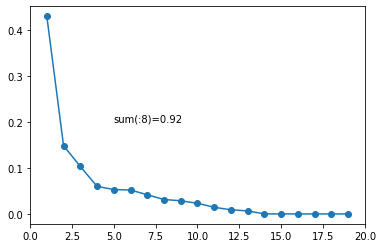

In [391]:
n_comp = 8
ratio = eighen_ratio_ims

plt.plot(range(1, len(ratio)+1), ratio,'o-')
plt.xlim(0, len(ratio)+1)
plt.text(5,0.2,'sum(:{0})={1:.2f}'.format(n_comp, np.sum(ratio[:n_comp])))

In [392]:
## Transform
pca = PCA(n_components=n_comp, random_state=SEED)
pca.fit(X_ims)

X_ims_pca = pca.transform(X_ims)
df_Xims_pca = pd.DataFrame(X_ims_pca, columns=['X%d'%i for i in range(n_comp)])
df_Xims_pca['Class'] = y_ims

df_Xims_pca.head()

,X0,X1,X2,X3,X4,X5,X6,X7,Class
0,-0.814209,-0.442137,-0.696477,-1.231562,0.597081,0.449747,-0.042883,0.348952,4
1,-2.431204,-0.760913,0.613989,0.779429,-1.069862,-0.553142,-0.850038,1.891136,2
2,-2.742324,-0.534286,-1.210012,0.616021,-1.107284,-0.387781,0.201732,0.003992,2
3,-2.019493,0.978603,-1.447891,-0.162561,-0.564682,0.232254,0.383482,-0.971117,2
4,-0.534979,-0.145034,-0.997975,-0.480278,0.112289,0.237871,-0.464036,0.808745,0


In [396]:
df_Xims_pca.to_csv('./ims_train_pca.csv')

### 2.1.2 Audit

In [393]:
## compute pca 
pca = PCA(random_state=SEED)
pca.fit(X_aud)

eighen_value_aud = pca.explained_variance_
eighen_ratio_aud = pca.explained_variance_ratio_

Text(5, 0.2, 'sum(:11)=0.97')

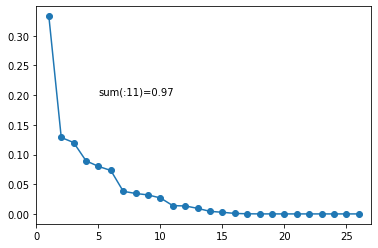

In [394]:
n_comp = 11
ratio = eighen_ratio_aud

plt.plot(range(1, len(ratio)+1), ratio,'o-')
plt.xlim(0, len(ratio)+1)
plt.text(5,0.2,'sum(:{0})={1:.2f}'.format(n_comp, np.sum(ratio[:n_comp])))

In [395]:
## Transform
pca = PCA(n_components=n_comp, random_state=SEED)
pca.fit(X_aud)

X_aud_pca = pca.transform(X_aud)
df_Xaud_pca = pd.DataFrame(X_aud_pca, columns=['X%d'%i for i in range(n_comp)])
df_Xaud_pca['Risk'] = y_aud

df_Xaud_pca.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,Risk
0,-1.841752,0.732479,0.457246,0.466915,-0.412948,0.927463,0.332086,0.320934,0.963005,0.291759,-0.231526,0
1,2.901058,-1.362267,-3.185441,0.713380,-1.526404,-1.126061,-0.679852,0.678360,0.096265,-0.286958,-0.285679,1
2,-1.647786,0.604780,0.268396,0.406441,-0.219883,0.411955,0.355904,-0.406803,-0.291185,0.139460,0.062823,0
3,-1.225684,0.322128,0.028571,0.274674,0.098196,-0.005991,-0.872965,0.107518,-1.010099,0.180467,0.053768,0
4,-0.305465,-0.011734,-0.812645,0.492487,0.673779,-1.694623,0.011227,-0.911904,-0.172850,0.508442,0.572559,0


In [397]:
df_Xaud_pca.to_csv('./aud_train_pca.csv')

## 2.2 ICA

In [415]:
## image segmentation
X_ori = X_ims
dimensions = range(2, X_ims.shape[1]+1)

kurt = []

for dim in dimensions:
    ica = FastICA(n_components=dim, random_state=SEED, max_iter=10000, tol=0.001, fun='exp')
    X_transform = ica.fit_transform(X_ori)
    X_kurt = stats.kurtosis(X_transform, fisher=True)
    k_val = np.mean(X_kurt ** 2)
#     X_kurt = np.abs().mean(stats.kurtosis(X_transform, fisher=True))
    kurt.append(k_val)
#     print(dim)

kurt_ims = pd.Series(kurt)

/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(0, 19.5)

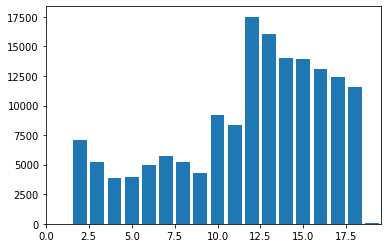

In [416]:
plt.bar(dimensions, kurt_ims)
plt.xlim(0, dimensions[-1]+0.5)

In [159]:
## transformation
n_comp = 12

ica = FastICA(n_components=n_comp, random_state=SEED, max_iter=10000, tol=0.001, fun='exp')

X_ims_ica = ica.fit_transform(X_ims)

df_Xims_ica = pd.DataFrame(X_ims_ica, columns=['X%d'%i for i in range(n_comp)])
df_Xims_ica['Class'] = y_ims

df_Xims_ica.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,Class
0,0.011516,-0.003108,-0.009306,0.010262,0.003843,-0.005457,0.029209,-0.006483,0.013248,-0.014829,0.008026,0.002313,4
1,-0.010451,-0.002418,-0.017057,0.074508,0.003686,-0.008977,-0.036921,0.000519,0.027842,-0.016331,0.011150,0.002419,2
2,0.001090,-0.002276,-0.013744,-0.019734,0.003513,-0.004755,-0.030625,0.013627,0.025177,-0.000354,0.009712,0.002246,2
3,0.002767,0.008298,0.020555,-0.043894,0.006996,0.010689,-0.004471,-0.007690,0.015668,-0.010435,0.007747,0.000542,2
4,0.020273,-0.002388,-0.002639,0.016152,0.004504,0.002552,0.008471,0.008665,0.020367,-0.000547,0.005806,-0.000006,0


In [398]:
df_Xims_ica.to_csv('./ims_train_ica.csv')

In [160]:
df_ims_comp = pd.DataFrame(ica.components_)
df_ims_comp.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000658,-3.376613e-03,-6.512325e-19,0.000542,-0.000662,-0.001466,0.000663,-0.000613,0.000476,-0.000641,-0.000075,-0.000060,-0.001874,0.005654,0.003350,-0.011345,-0.000751,-0.001379,-0.011330
1,-0.000156,-5.106406e-07,3.941065e-18,0.000239,-0.000453,-0.000580,0.025469,0.000991,-0.002862,0.000190,0.000257,0.000107,0.000223,0.000456,-0.000400,0.000220,0.000079,0.000033,-0.000031
2,0.000604,-4.767396e-03,-5.335207e-18,-0.000563,-0.003584,0.033072,-0.017188,-0.001250,-0.000683,0.000533,0.000832,0.000038,0.000833,0.002272,-0.002868,0.002581,0.000132,0.000565,-0.000887
3,-0.000483,-9.015128e-03,2.680050e-18,-0.001790,0.001737,-0.001440,0.001148,-0.001637,0.000433,-0.004139,-0.004423,-0.003229,-0.004911,0.000794,0.002681,-0.005339,-0.003300,-0.028176,0.008447
4,-0.000220,-4.334451e-04,1.048591e-18,-0.000116,-0.024098,0.001389,0.000831,-0.000506,0.004599,-0.000141,-0.000175,-0.000079,-0.000181,-0.000195,0.000300,-0.000312,-0.000071,-0.000036,0.000075


In [172]:
## aud
X_ori = X_aud

dimensions = range(2, X_orig.shape[1]+1)
kurt = []
for dim in dimensions:
    ica = FastICA(n_components=dim, random_state=SEED, max_iter=1000, tol=0.001, fun='exp')
    X_transform = ica.fit_transform(X_ori)
    X_kurt = stats.kurtosis(X_transform, fisher=True)
    k_val = np.mean(X_kurt ** 2)
    kurt.append(k_val)

kurt_aud = pd.Series(kurt)

/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/lei/anaconda3/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


(0, 26.5)

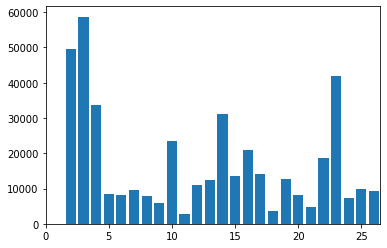

In [175]:
plt.bar(dimensions, kurt_aud)
plt.xlim(0, dimensions[-1]+0.5)

In [176]:
## transformation
n_comp = 3

ica = FastICA(n_components=n_comp, random_state=SEED, max_iter=10000, tol=0.001, fun='exp')

X_aud_ica = ica.fit_transform(X_aud)

df_Xaud_ica = pd.DataFrame(X_aud_ica, columns=['X%d'%i for i in range(n_comp)])
df_Xaud_ica['Class'] = y_aud

df_Xaud_ica.head()

,X0,X1,X2,Class
0,0.017359,-0.026339,0.005785,0
1,0.001370,0.088944,0.004128,1
2,0.016588,-0.020581,0.006504,0
3,0.012628,-0.011206,0.007434,0
4,0.012354,0.013150,0.006591,0


In [399]:
df_Xaud_ica.to_csv('./aud_train_ica.csv')

## 2.3 Randomized Projections

In [186]:
from collections import defaultdict
import scipy.sparse as sps
from scipy.linalg import pinv
from sklearn.utils.extmath import safe_sparse_dot

def reconstructX(component_matrix, X_new):
    A = component_matrix.todense()
    X_re = safe_sparse_dot(X_new, pinv(A.T), dense_output=True)
    
    return X_re

### 2.3.1 Image segmentation

In [190]:
## compute SRP
X_ori = X_ims
dimensions = range(2, X_ims.shape[1]+1)

error = []
for dim in dimensions:
    srp = SparseRandomProjection(n_components=dim, random_state=SEED)
    X_new = srp.fit_transform(X_ori)
    X_rec = reconstructX(srp.components_, X_new)
    rec_error = np.nanmean(np.square(X_ori - X_rec))
    error.append(rec_error)
    
SRP_err_ims = error

(1, 19)

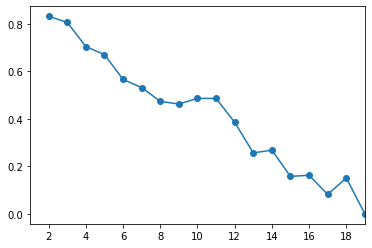

In [191]:
plt.plot(dimensions, SRP_err_ims, '-o')
plt.xlim(1, dimensions[-1])

In [194]:
## transform SRP
n_comp = 10

srp = SparseRandomProjection(n_components=n_comp, random_state=SEED)

X_ims_srp = srp.fit_transform(X_ims)

df_Xims_srp = pd.DataFrame(X_ims_srp, columns=['X%d'%i for i in range(n_comp)])
df_Xims_srp['Class'] = y_ims

df_Xims_srp.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,Class
0,-0.236668,0.064557,0.314702,0.201101,-0.316416,-0.704470,-0.506996,-0.088662,0.146466,-0.170061,4
1,1.463652,0.227675,0.670382,0.177941,-0.224290,1.375289,-1.246892,0.487758,-0.261541,-0.455602,2
2,0.530551,0.200489,0.660268,0.222762,-0.279330,0.332960,-1.181407,0.449753,-0.250722,-0.337477,2
3,0.207836,-0.683070,0.532156,1.266351,-1.201102,-0.911678,0.426486,0.031690,-0.697569,0.569259,2
4,-0.719851,-0.071375,0.210190,-0.354873,-0.785902,-0.319156,-0.851032,0.392744,-0.582370,-0.271540,0


In [400]:
df_Xims_srp.to_csv('./ims_train_srp.csv')

### 2.3.2 Audit

In [195]:
## audit
X_ori = X_aud
dimensions = range(2, X_aud.shape[1]+1)

error = []
for dim in dimensions:
    srp = SparseRandomProjection(n_components=dim, random_state=SEED)
    X_new = srp.fit_transform(X_ori)
    X_rec = reconstructX(srp.components_, X_new)
    rec_error = np.nanmean(np.square(X_ori - X_rec))
    error.append(rec_error)
    
SRP_err_aud = error

(1, 26)

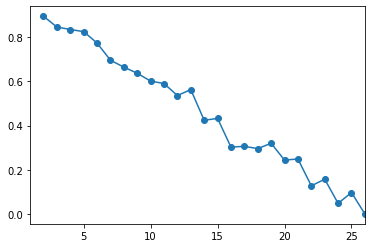

In [196]:
plt.plot(dimensions, SRP_err_aud, '-o')
plt.xlim(1, dimensions[-1])

In [197]:
## transform SRP
n_comp = 13

srp = SparseRandomProjection(n_components=n_comp, random_state=SEED)

X_aud_srp = srp.fit_transform(X_aud)

df_Xaud_srp = pd.DataFrame(X_aud_srp, columns=['X%d'%i for i in range(n_comp)])
df_Xaud_srp['Class'] = y_aud

df_Xaud_srp.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,Class
0,0.343047,0.223165,0.206136,-0.369866,1.054392,-0.377007,0.820035,0.285513,0.990423,-0.076128,0.097096,0.905694,0.634336,0
1,0.212798,-0.291592,0.365211,1.116042,-2.370866,0.303065,-1.479142,0.235741,-2.008449,-1.127815,0.168243,-1.926460,-0.562631,1
2,0.341233,0.178677,0.213275,-0.370966,1.362984,-0.399135,0.767572,0.281165,0.979482,-0.070681,0.102504,0.911141,-0.350962,0
3,0.343047,0.067346,0.201722,-0.371535,-0.042716,0.223750,0.665885,0.287181,0.992255,-0.076128,0.114219,0.905694,-0.136837,0
4,0.342922,-0.293149,0.207674,-0.380187,0.426978,0.504924,-0.423659,0.295458,0.249928,-0.075753,0.152857,0.906069,0.579213,0


In [401]:
df_Xaud_srp.to_csv('./aud_train_srp.csv')

## 2.4 Random Forest

### 2.4.1 Image segmentation

In [332]:
## compute rfc
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED, n_jobs=-1)

rfc.fit(X_ims, y_ims)
rfc_fi_ims = rfc.feature_importances_

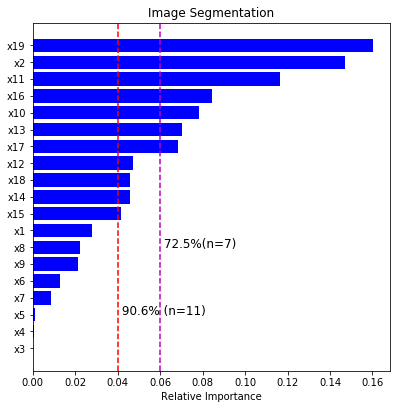

In [333]:
feature_names = X_ims.columns
fi = rfc_fi_ims
indices = np.argsort(fi)
thresh1 = 0.04
thresh2 = 0.06
sel1 = fi >= thresh1
sel2 = fi >= thresh2
per_sel1 = sum(fi[sel1])
per_sel2 = sum(fi[sel2])
n_sel1 = len(fi[sel1])
n_sel2 = len(fi[sel2])

plt.figure(figsize=(6.4,6.4))
plt.title('Image Segmentation')
plt.barh(range(len(indices)), fi[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

plt.axvline(thresh1, ls='--',c='r')
plt.text(thresh1, 2, ' {0:4.1f}% (n={1})'.format(per_sel1*100, n_sel1), size=12)
plt.axvline(thresh2, ls='--',c='m')
plt.text(thresh2, 6, ' {0:4.1f}%(n={1})'.format(per_sel2*100, n_sel2), size=12)

plt.show()

In [250]:
## transform rf
df_Xims_rf = X_ims.iloc[:,sel1].copy()
df_Xims_rf['Class'] = y_ims
df_Xims_rf.head()

,x2,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,Class
0,-0.268261,-0.527290,-0.549991,-0.476663,-0.560219,0.222756,-0.094713,-0.062901,-0.505518,-0.022861,-0.488512,4
1,0.166738,-0.970747,-0.936970,-1.015392,-0.939178,1.095830,-1.094098,0.754861,-1.051850,-1.870205,0.882133,2
2,0.236338,-0.964924,-0.936970,-1.000073,-0.939178,1.038264,-1.025958,0.697137,-1.036314,1.050441,-0.473461,2
3,-0.216061,-0.842658,-0.873531,-0.806028,-0.847494,0.405046,-0.446769,0.350790,-0.839531,1.917863,-0.552476,2
4,-0.546660,-0.350683,-0.277203,-0.318363,-0.456311,0.951916,-0.071999,-0.832560,-0.344984,-0.025937,-0.177916,0


In [402]:
df_Xims_rf.to_csv('./ims_train_rf.csv')

### 2.4.2 Audit

In [371]:
## audit
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=SEED, n_jobs=-1)

rfc.fit(X_aud, y_aud)
rfc_fi_aud = rfc.feature_importances_

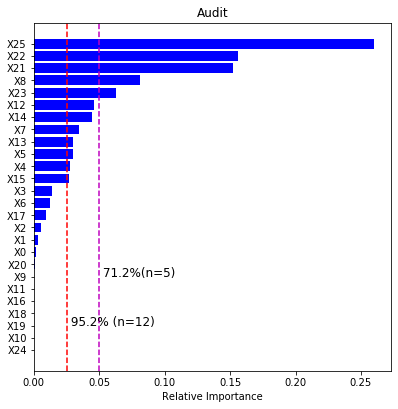

In [372]:
feature_names = ['X%d'%i for i in range(len(X_aud.columns))]
fi = rfc_fi_aud
indices = np.argsort(fi)
thresh1 = 0.025
thresh2 = 0.05
sel1 = fi >= thresh1
sel2 = fi >= thresh2
per_sel1 = sum(fi[sel1])
per_sel2 = sum(fi[sel2])
n_sel1 = len(fi[sel1])
n_sel2 = len(fi[sel2])

plt.figure(figsize=(6.4,6.4))
plt.title('Audit')
plt.barh(range(len(indices)), fi[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

plt.axvline(thresh1, ls='--',c='r')
plt.text(thresh1, 2, ' {0:4.1f}% (n={1})'.format(per_sel1*100, n_sel1), size=12)
plt.axvline(thresh2, ls='--',c='m')
plt.text(thresh2, 6, ' {0:4.1f}%(n={1})'.format(per_sel2*100, n_sel2), size=12)

plt.show()

In [301]:
## transform rf
df_Xaud_rf = X_aud.iloc[:,sel1].copy()
df_Xaud_rf['Class'] = y_aud
df_Xaud_rf.head()

,Risk_A,PARA_B,Risk_B,TOTAL,Money_Value,Score_MV,Risk_D,District_Loss,Score,Inherent_Risk,CONTROL_RISK,Audit_Risk,Class
0,-0.393983,-0.211978,-0.209867,-0.254162,-0.212801,-0.571851,-0.207471,-0.412647,-0.822048,-0.297630,-0.38982,-0.178498,0
1,0.704714,0.170684,0.175425,0.242102,-0.004665,1.929391,0.000500,-0.412647,1.971589,0.156868,-0.38982,-0.049833,1
2,-0.367284,-0.198824,-0.205486,-0.232374,-0.204104,-0.571851,-0.204574,-0.412647,-0.822048,-0.291429,-0.38982,-0.176743,0
3,-0.231471,-0.216363,-0.211328,-0.231206,-0.212801,-0.571851,-0.207471,-0.412647,-0.589245,-0.288220,-0.38982,-0.175834,0
4,0.406969,-0.193044,-0.195794,-0.146194,-0.212201,-0.571851,-0.207271,-0.412647,0.341967,-0.239418,-0.38982,-0.162019,0


In [403]:
df_Xaud_rf.to_csv('./aud_train_rf.csv')

## 3. Plot

In [389]:
### Image Segmentation

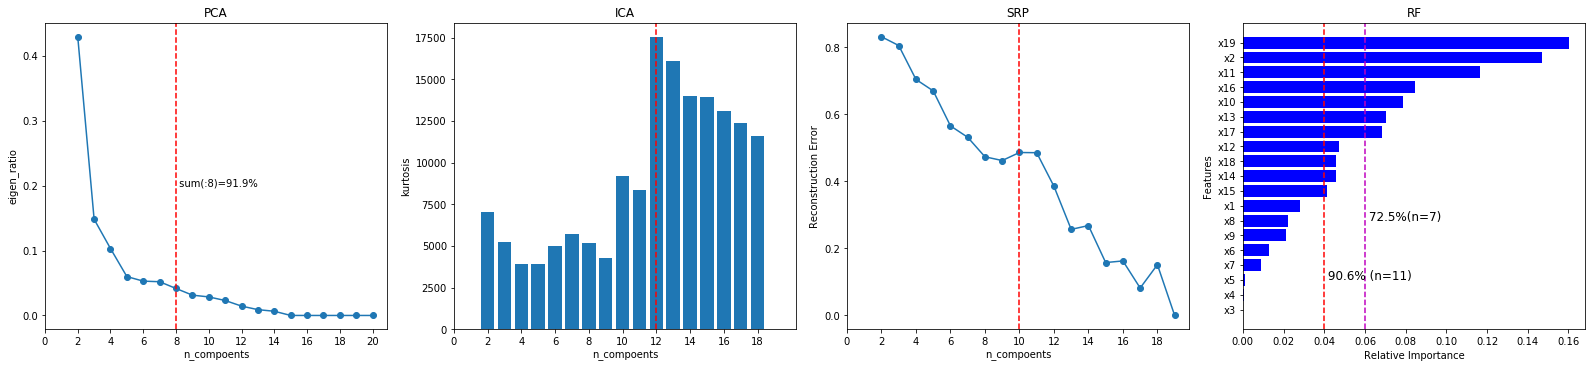

In [417]:
fig = plt.figure(figsize=(22,5),constrained_layout=True)
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0],title='PCA')
n_comp = 8
ratio = eighen_ratio_ims
x = list(range(2, len(ratio)+2))
ax1.plot(x, ratio,'o-')
_ = ax1.set_xticks([0] + x[::2])
ax1.set_xlabel('n_compoents')
ax1.set_ylabel('eigen_ratio')
ax1.axvline(n_comp, ls='--',c='r')
ax1.text(n_comp,0.2,' sum(:{0})={1:4.1f}%'.format(n_comp, np.sum(ratio[:n_comp])*100))


ax2 = fig.add_subplot(gs[0, 1], title='ICA')
x = list(range(2, len(kurt_ims)+2))
ax2.bar(x, kurt_ims)
_ = ax2.set_xticks([0] + x[::2])
ax2.set_xlabel('n_compoents')
ax2.set_ylabel('kurtosis')
ax2.axvline(12, ls='--',c='r')

ax3 = fig.add_subplot(gs[0, 2],title='SRP')
x = list(range(2, len(SRP_err_ims)+2))
ax3.plot(x, SRP_err_ims, '-o')
_ = ax3.set_xticks([0] + x[::2])
ax3.set_xlabel('n_compoents')
ax3.set_ylabel('Reconstruction Error')
ax3.axvline(10, ls='--',c='r')

ax4 = fig.add_subplot(gs[0, 3],title='RF')
feature_names = X_ims.columns
fi = rfc_fi_ims
indices = np.argsort(fi)
thresh1 = 0.04
thresh2 = 0.06
sel1 = fi >= thresh1
sel2 = fi >= thresh2
per_sel1 = sum(fi[sel1])
per_sel2 = sum(fi[sel2])
n_sel1 = len(fi[sel1])
n_sel2 = len(fi[sel2])

ax4.barh(range(len(indices)), fi[indices], color='b', align='center')
ax4.set_yticks(range(len(indices)))
ax4.set_yticklabels([feature_names[i] for i in indices])
ax4.set_xlabel('Relative Importance')
ax4.set_ylabel('Features')

ax4.axvline(thresh1, ls='--',c='r')
ax4.text(thresh1, 2, ' {0:4.1f}% (n={1})'.format(per_sel1*100, n_sel1), size=12)
ax4.axvline(thresh2, ls='--',c='m')
ax4.text(thresh2, 6, ' {0:4.1f}%(n={1})'.format(per_sel2*100, n_sel2), size=12)


plt.show()

### Audit

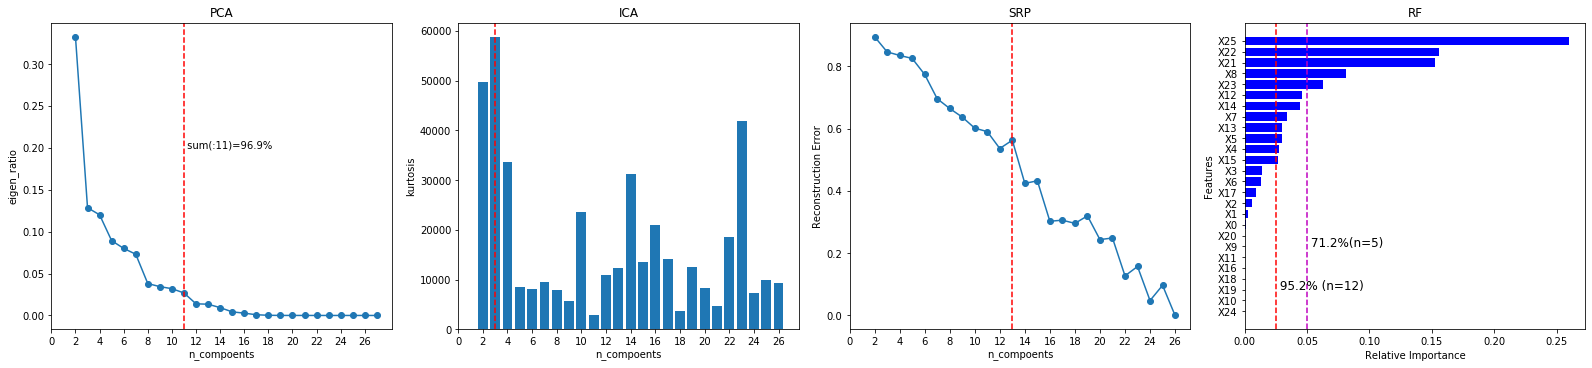

In [388]:
fig = plt.figure(figsize=(22,5),constrained_layout=True)
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0],title='PCA')
n_comp = 11
ratio = eighen_ratio_aud
x = list(range(2, len(ratio)+2))
ax1.plot(x, ratio,'o-')
_ = ax1.set_xticks([0] + x[::2])
ax1.set_xlabel('n_compoents')
ax1.set_ylabel('eigen_ratio')
ax1.axvline(n_comp, ls='--',c='r')
ax1.text(n_comp,0.2,' sum(:{0})={1:4.1f}%'.format(n_comp, np.sum(ratio[:n_comp])*100))

ax2 = fig.add_subplot(gs[0, 1], title='ICA')
x = list(range(2, len(kurt_aud)+2))
ax2.bar(x, kurt_aud)
_ = ax2.set_xticks([0] + x[::2])
ax2.set_xlabel('n_compoents')
ax2.set_ylabel('kurtosis')
ax2.axvline(3, ls='--',c='r')

ax3 = fig.add_subplot(gs[0, 2],title='SRP')
x = list(range(2, len(SRP_err_aud)+2))
ax3.plot(x, SRP_err_aud, '-o')
_ = ax3.set_xticks([0] + x[::2])
ax3.set_xlabel('n_compoents')
ax3.set_ylabel('Reconstruction Error')
ax3.axvline(13, ls='--',c='r')

ax4 = fig.add_subplot(gs[0, 3],title='RF')
feature_names = ['X%d'%i for i in range(len(X_aud.columns))]
fi = rfc_fi_aud
indices = np.argsort(fi)
thresh1 = 0.025
thresh2 = 0.05
sel1 = fi >= thresh1
sel2 = fi >= thresh2
per_sel1 = sum(fi[sel1])
per_sel2 = sum(fi[sel2])
n_sel1 = len(fi[sel1])
n_sel2 = len(fi[sel2])

ax4.barh(range(len(indices)), fi[indices], color='b', align='center')
ax4.set_yticks(range(len(indices)))
ax4.set_yticklabels([feature_names[i] for i in indices])
ax4.set_xlabel('Relative Importance')
ax4.set_ylabel('Features')

ax4.axvline(thresh1, ls='--',c='r')
ax4.text(thresh1, 2, ' {0:4.1f}% (n={1})'.format(per_sel1*100, n_sel1), size=12)
ax4.axvline(thresh2, ls='--',c='m')
ax4.text(thresh2, 6, ' {0:4.1f}%(n={1})'.format(per_sel2*100, n_sel2), size=12)


plt.show()